In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
from lb2jpsil import lorentz
import random
from typing import Tuple
from scipy import optimize
import time

In [2]:
## Self explanatory
save_plots = False
save_results = False

In [3]:
#n_experiments = 10000
n_experiments = 100
events_per_experiment = 20000

In [4]:
add_smearing = False
theta_smearing = 0.097
phi_smearing = 0.332

# A look at the PDF

In [5]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [6]:
## in eV
m_electron = 0.511e6
m_lambda = 1116e6

## in eV/T
bohr_magneton = 5.788e-5

## in eV s
hbar = 6.582e-16

## in m/s
c = 299792458.

In [7]:
hbar * c

1.973233958556e-07

In [8]:
## Assuming EDM is 0
def particle_magneton(m_particle):
    return bohr_magneton * m_electron / m_lambda

def phi_rot(g: float, Dy: float, beta: float, m_particle: float):
    muB = particle_magneton(m_particle)
    return g * Dy * muB / (beta * hbar * c)

In [9]:
def pdf(theta, phi, sz=1, g=1.226, Dy=4, beta=1.):
    #alpha = 0.642
    alpha = 0.732
    
    Phi_rot = phi_rot(g, Dy, beta, m_lambda)
    
    s = np.array([
        - sz * np.sin(Phi_rot),
        0,
        sz * np.cos(Phi_rot)
    ])
    
    k_hat = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])
    
    return 1 + alpha * scalar_product(s, k_hat)

In [10]:
theta_min = 0
theta_max = 2*np.pi
phi_min = -np.pi
phi_max = np.pi

bins = 100

theta_list = np.linspace(theta_min, theta_max, bins)
phi_list = np.linspace(phi_min, phi_max, bins)

theta_grid, phi_grid = np.meshgrid(theta_list, phi_list)
ys = pdf(theta_grid, phi_grid)

In [11]:
ys.min()

0.2680219531789225

In [12]:
ys.max()

1.7317893965015245

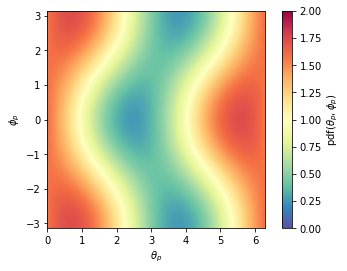

In [13]:
plt.imshow(ys,extent=[theta_min, theta_max,phi_min, phi_max], cmap='Spectral_r', origin='lower')
plt.clim(0,2)
plt.colorbar(label=r"$\mathrm{pdf}(\theta_p,\phi_p)$")
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

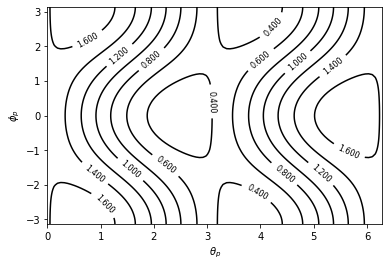

In [14]:
contours = plt.contour(theta_grid, phi_grid, ys, colors='k')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

# Event generation

In [15]:
class Generator:
    
    def __init__(self,
        event_number: int, 
        random_state: int = 2022,
        theta_resolution = None,
        phi_resolution = None
    ):
        self._event_number = event_number
        self._random_state = random_state
        random.seed(random_state)
        
        self._theta_resolution = theta_resolution
        if self._theta_resolution is not None:
             self._smear_theta = True
        else:
             self._smear_theta = False
        
        self._phi_resolution = phi_resolution
        if self._phi_resolution is not None:
             self._smear_phi = True
        else:
             self._smear_phi = False
    
    ## Getter and setter methods
    ### Event number
    @property
    def event_number(self) -> int:
        return self._event_number
    
    @event_number.setter
    def event_number(self, n) -> None:
        self._event_number = n
    
    ### Random state
    @property
    def random_state(self) -> int:
        return self._random_state
    
    @random_state.setter
    def random_state(self, n) -> None:
        self._random_state = n
        random.seed(n)
    
    ### Theta resolution
    @property
    def theta_resolution(self) -> float:
        return self._theta_resolution
    
    ### Theta smearing
    @property
    def smear_theta(self) -> bool:
        return self._smear_theta
    
    ### Phi resolution
    @property
    def phi_resolution(self) -> float:
        return self._phi_resolution
    
    ### Phi smearing
    @property
    def smear_phi(self) -> bool:
        return self._smear_phi
    
    ## Method to smear theta and phi with a gaussian of resolution sigma
    def smear_angle(self, angle: float, sigma: float, allowed_region: Tuple[float]):
        reco_angle = random.gauss(angle, sigma)
        left_bound = allowed_region[0]
        right_bound = allowed_region[1]
        
        ## Take theta as an example: if it's in [0,2pi] all is well
        if left_bound <= reco_angle <= right_bound:
            return reco_angle
        ## If it's not, you have to "wrap it around"
        elif reco_angle < left_bound:
            return right_bound - (left_bound - reco_angle)
        elif reco_angle > right_bound:
            return left_bound + (reco_angle - right_bound)
        else:
            raise ValueError
        
    ## Individual generators
    def generate_omega(self) -> Tuple[float]:
        pdf_min = 0
        pdf_max = 2
                
        accept = False
        while accept is not True:
            theta = random.uniform(0,2*np.pi)
            phi = random.uniform(-np.pi,np.pi)
            yref = random.uniform(pdf_min, pdf_max)
            
            if yref <= pdf(theta, phi):
                accept = True
                
        if self._smear_theta:
            theta = self.smear_angle(theta, self._theta_resolution, (0, 2*np.pi))
        
        if self._smear_phi:
            phi = self.smear_angle(phi, self._phi_resolution, (-np.pi, np.pi))
        
        return theta, phi
    
    ## For now it's very simplified: lambda momentum along z, maximal polarization s0 = 1, g=1.226, Dy = 4 T m, beta= 1
    def generate_event(self) -> dict:
        own_vertex = [0,0, random.uniform(0,1000)]
        momentum = [0,0,random.uniform(0,10000)]
        decay_length = random.uniform(0,5000)
        
        end_vertex = [
            random.uniform(-1000,1000),
            random.uniform(-1000,1000),
            random.uniform(5500,8500)
        ]
        
        theta, phi = self.generate_omega()
        
        event_dict = {
            'L_OWNVERTEX_X': own_vertex[0],
            'L_OWNVERTEX_Y': own_vertex[1],
            'L_OWNVERTEX_Z': own_vertex[2],
            'L_PX': momentum[0],
            'L_PY': momentum[1],
            'L_PZ': momentum[2],
            'L_DECAYLENGTH': decay_length,
            'L_ENDVERTEX_X': end_vertex[0],
            'L_ENDVERTEX_Y': end_vertex[1],
            'L_ENDVERTEX_Z': end_vertex[2],
            'THETA': theta,
            'PHI': phi
        }
        
        return event_dict
    
    def generate_sample(self) -> pd.DataFrame:
        events = []
        
        for i in range(self._event_number):
            events.append(self.generate_event())
        
        df = pd.DataFrame(events)
        
        return df

In [16]:
if add_smearing:
    pseudo_experiment_generator = Generator(event_number=events_per_experiment, random_state=2021, theta_resolution=theta_smearing, phi_resolution=phi_smearing)
else:
    pseudo_experiment_generator = Generator(event_number=events_per_experiment, random_state=2021)
df_generated = pseudo_experiment_generator.generate_sample()
df_generated

,L_OWNVERTEX_X,L_OWNVERTEX_Y,L_OWNVERTEX_Z,L_PX,L_PY,L_PZ,L_DECAYLENGTH,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,THETA,PHI
0,0,0,836.337502,0,0,8583.024042,2720.551650,-505.335333,270.041183,8420.895564,2.984742,2.596495
1,0,0,829.550527,0,0,7432.948284,3368.925665,95.683549,-898.001886,7979.710184,2.485044,-2.433953
2,0,0,983.102862,0,0,4425.830206,578.889163,84.715847,-72.806918,6348.350858,0.857329,-3.110717
3,0,0,884.827839,0,0,1948.291120,851.010786,621.912468,-197.617286,7244.148716,2.312839,2.024806
4,0,0,76.583766,0,0,1749.507255,2925.456891,395.642373,158.067258,7389.749958,5.853460,-0.646478
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,282.678825,0,0,3584.273545,856.768607,519.356622,825.819835,6401.876347,2.759303,-1.356532
19996,0,0,982.321418,0,0,9307.040631,2276.027046,768.618411,796.388077,6452.753792,4.848316,-1.170953
19997,0,0,920.814319,0,0,4388.268639,4839.328506,238.655075,381.491134,6385.790181,0.096139,-1.215913
19998,0,0,929.031050,0,0,738.479370,1436.330560,437.653709,-508.438336,8248.182495,3.868582,-0.109894


# Analysis of generated events

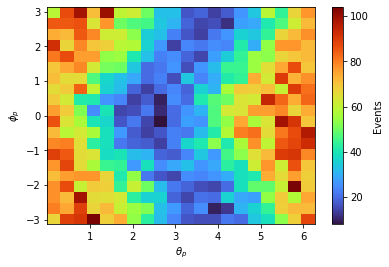

In [17]:
plt.hist2d(df_generated['THETA'], df_generated['PHI'], cmap='turbo', bins=20)
plt.colorbar(label='Events')
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

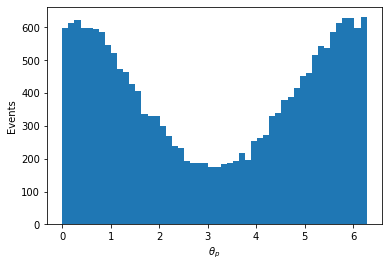

In [18]:
plt.hist(df_generated['THETA'],bins=50)
plt.xlabel(r"$\theta_p$")
plt.ylabel("Events")
plt.show()

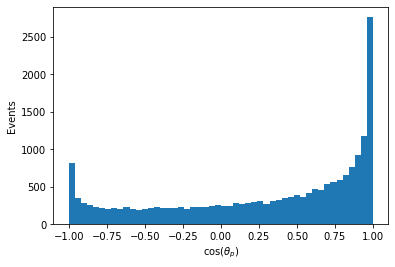

In [19]:
plt.hist(np.cos(df_generated['THETA']),bins=50)
plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel("Events")
plt.show()

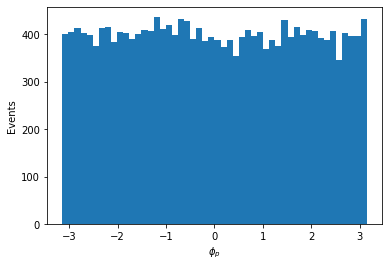

In [20]:
plt.hist(df_generated['PHI'],bins=50)
plt.xlabel(r"$\phi_p$")
plt.ylabel("Events")
plt.show()

# Fit of events

In [21]:
def function_for_fit(xdata: np.array, S: float, g: float) -> float:
    theta, phi = xdata
    return S * pdf(theta, phi, g=g)

In [22]:
fit_func = {
     'param_names' : [r'S',  r'g'],
     'p0'          : [100,   1.2],
     'lb'          : [1,     0.5],
     'ub'          : [100000, 2]
}

In [23]:
def pdg_round(value, error) :
    "Given a value and an error, round and format them according to the PDG rules for significant digits"
    def three_digits(value) :
        "extract the three most significant digits and return them as an int"
        return int(("%.2e"%float(error)).split('e')[0].replace('.','').replace('+','').replace('-',''))
    def n_significant_digits(three_digits) :
        assert three_digits<1000,"three digits (%d) cannot be larger than 10^3"%three_digits
        if three_digits<101 : return 2 # not sure
        elif three_digits<356 : return 2
        elif three_digits<950 : return 1
        else : return 2
    def frexp10(value) :
        "convert to mantissa+exp representation (same as frex, but in base 10)"
        valueStr = ("%e"%float(value)).split('e')
        return float(valueStr[0]), int(valueStr[1])
    def n_digits_value(expVal, expErr, nDigitsErr) :
        "compute the number of digits we want for the value, assuming we keep nDigitsErr for the error"
        return expVal-expErr+nDigitsErr
    def format_value(value, exponent, nDigits, extraRound=0) :
        "Format the value; extraRound is meant for the special case of three_digits>950"
        roundAt = nDigits-1-exponent - extraRound
        nDec = roundAt if exponent<nDigits else 0
        nDec = max([nDec, 0])
        return ('%.'+str(nDec)+'f')%round(value,roundAt)
    tD = three_digits(error)
    nD = n_significant_digits(tD)
    expVal, expErr = frexp10(value)[1], frexp10(error)[1]
    extraRound = 1 if tD>=950 else 0
    return (format_value(value, expVal, n_digits_value(expVal, expErr, nD), extraRound),
            format_value(error,expErr, nD, extraRound))

In [24]:
def fit_generated_sample(generator: Generator, binning=10) -> dict:
    
    df_gen = generator.generate_sample()
    
    evt_number, theta_edges, phi_edges, _ = plt.hist2d(df_gen['THETA'], df_gen['PHI'], bins=binning)
    
    theta_midpoints = (theta_edges[:-1] + theta_edges[1:])/2
    phi_midpoints = (phi_edges[:-1] + phi_edges[1:])/2
    theta_grid_data, phi_grid_data = np.meshgrid(theta_midpoints, phi_midpoints)
    
    #plt.pcolormesh(theta_grid_data, phi_grid_data, evt_number.T, cmap='turbo', shading='auto')
    #plt.xlabel(r"$\theta_p$")
    #plt.ylabel(r"$\phi_p$")
    #plt.colorbar()
    #plt.show()
    
    xdata = np.vstack((theta_grid_data.ravel(), phi_grid_data.ravel()))
    ydata = evt_number.T.ravel()
    
    param_best, param_covmatrix = optimize.curve_fit(
        f=function_for_fit,
        xdata=xdata,
        ydata=ydata,
        p0=fit_func['p0'],
        sigma=np.sqrt(ydata),
        bounds=(
            fit_func['lb'],
            fit_func['ub']
        )
    )
    
    param_names = fit_func['param_names']
    param_error = np.sqrt(np.diag(param_covmatrix))
    
    fit_results_dictionary = {}
    
    for name, best, error in zip(param_names, param_best, param_error):
        fit_results_dictionary[name] = best
        fit_results_dictionary[f'{name}_ERR'] = error

    return fit_results_dictionary

In [25]:
tick = time.perf_counter()

Processing pseudoexperiment 0...
Processing pseudoexperiment 10...
Processing pseudoexperiment 20...
Processing pseudoexperiment 30...
Processing pseudoexperiment 40...
Processing pseudoexperiment 50...
Processing pseudoexperiment 60...
Processing pseudoexperiment 70...
Processing pseudoexperiment 80...
Processing pseudoexperiment 90...


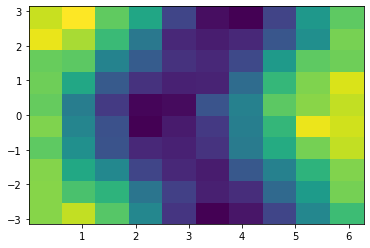

In [26]:
fit_results = []
pseudoexperiments_run = 0
sigma_zero_counter = 0

while True:
    
    if pseudoexperiments_run % (n_experiments/10) == 0:
        print(f"Processing pseudoexperiment {pseudoexperiments_run}...")
    
    try:
        fit_results.append(fit_generated_sample(pseudo_experiment_generator))
    except ValueError:
        continue
    
    pseudoexperiments_run += 1
    
    if pseudoexperiments_run >= n_experiments:
        sigma_zero_counter += 1
        break

df_fit_results = pd.DataFrame(fit_results)

In [27]:
tock = time.perf_counter()
print(f"Pseudoexperiments produced in {(tock - tick)/60:0.4f} minutes.")
print(f"Sigma_0 counter:", sigma_zero_counter)

Pseudoexperiments produced in 1.2763 minutes.
Sigma_0 counter: 1


In [28]:
df_fit_results

,S,S_ERR,g,g_ERR
0,198.685913,1.633431,1.176325,0.032781
1,199.130289,1.333392,1.266001,0.026295
2,199.132926,1.331228,1.211775,0.026614
3,198.935024,1.473840,1.226554,0.029409
4,199.054463,1.390725,1.217420,0.027532
...,...,...,...,...
95,199.133690,1.329165,1.263495,0.026136
96,198.720450,1.613241,1.259917,0.031815
97,199.116161,1.346021,1.209692,0.026851
98,198.842616,1.534392,1.220447,0.030446


In [29]:
output_dir = './'
output_file = output_dir + 'pseudoexperiments.h5'

if save_results:
    df_fit_results.to_hdf(output_file, 'LHCb_Pseudo', 'w')
    print(f"Output saved.")

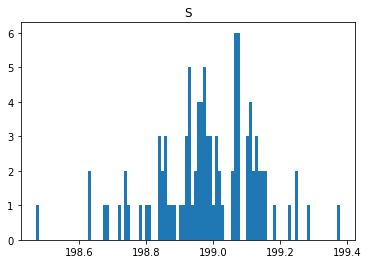

In [30]:
plt.hist(df_fit_results['S'], bins=100)
plt.title("S")
plt.show()

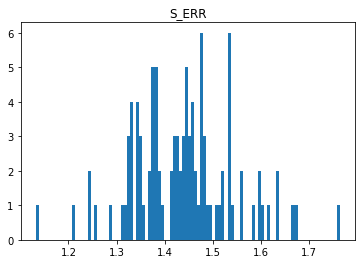

In [31]:
plt.hist(df_fit_results['S_ERR'], bins=100)
plt.title("S_ERR")
plt.show()

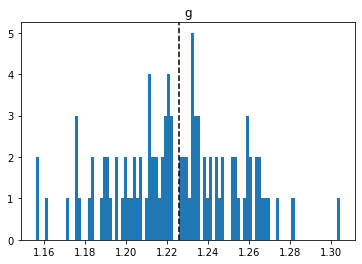

In [32]:
plt.hist(df_fit_results['g'], bins=100)
plt.axvline(1.226, color='k', linestyle='--')
plt.title("g")
plt.show()

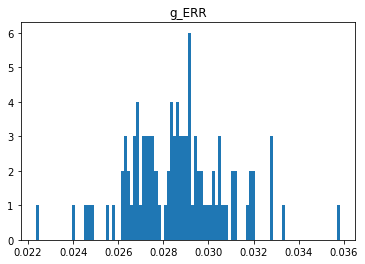

In [33]:
plt.hist(df_fit_results['g_ERR'], bins=100)
plt.title("g_ERR")
plt.show()

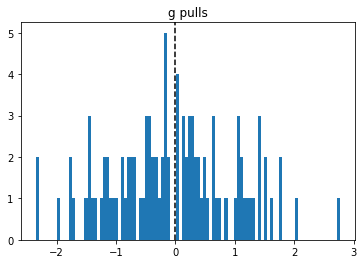

In [34]:
plt.hist((df_fit_results['g'] - 1.226)/df_fit_results['g_ERR'], bins=100)
plt.axvline(0, color='k', linestyle='--')
plt.title("g pulls")
plt.show()

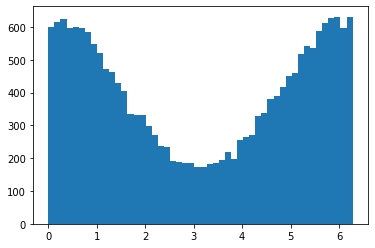

In [46]:
plt.hist(df_generated['THETA'],bins=50)
plt.show()